In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ReferenceElement import *
from dg_nonlinear_coord_trans import *

In [28]:
start = -5.
end = 10.
N = 20
K = 9
CF = 2.**(-7)
v = 0.2
xi_p = 0.
gamma = 1/np.sqrt(1-v**2)

h = (end-start)/K
reference_element = ReferenceElement(N)
reference_interval = reference_element[0]
M_inv = reference_element[1]*2/h
M_inv_S = reference_element[2]*2/h
xi_int = get_x_elements(start,end,K, reference_interval)
dx_min = get_dx_min(xi_int)
dt = CF*dx_min
for i in range(len(xi_int)):
        if np.round(xi_int[i][-1],6) == np.round(xi_p,6):
            k_p = i
            break
print(k_p)

2


In [29]:

def x_p(t):
    return v*t
def x_p_dot(t):
    return v
def xi_to_x(xi,a,b,t,x_p, xi_p):
    x = a + (x_p(t)-a)*(xi-a)/(xi_p-a) + ((b-x_p(t))*(xi_p-a)-(x_p(t)-a)*(b-xi_p))/((xi_p-a)*(b-xi_p)*(b-a))*(xi-a)*(xi-xi_p)    
    return x
def ana_u(x,v,t):
    gamma = 1/np.sqrt(1-v**2)
    v_style = gamma**2*(t-x*v-np.abs(x-v*t))
    return -1/2*np.sin(v_style)
def ana_du_dx(x,v,t):
    gamma = 1/np.sqrt(1-v**2)
    v_style = gamma**2*(t-x*v-np.abs(x-v*t))
    return 1/2*gamma**2*(v+np.sign(x-v*t))*np.cos(v_style)
def ana_du_dt(x,v,t):
    gamma = 1/np.sqrt(1-v**2)
    v_style = gamma**2*(t-x*v-np.abs(x-v*t))
    return -1/2*gamma**2*(1+v*np.sign(x-v*t))*np.cos(v_style)
def J1(beta, dx_dxi, t):
    gap_p = v*gamma**2*np.cos(t)
    gap_q = dx_dxi*gamma**2*np.cos(t)
    return -beta*gap_p+gap_q/dx_dxi**2
def J2(beta, dx_dxi,t):
    gap_p = v*gamma**2*np.cos(t)
    gap_q = dx_dxi*gamma**2*np.cos(t)
    return -beta*gap_q+gap_p

In [30]:
t = 0.
t_target = 5.
x = xi_to_x(xi_int,start,end,t,x_p,xi_p)
beta_initial = func_beta(start,end,t,xi_p,xi_int,x_p,x_p_dot)
u = ana_u(x,v,t)
q = ana_du_dx(x,v,t)
p = beta_initial*q - ana_du_dt(x,v,t)
# u = np.zeros_like(x)
# p = np.zeros_like(x)
# q = np.zeros_like(x)
nt = int((t_target - t)/dt)
print(nt)

44067


In [31]:
beta = func_beta(start,end,t,xi_p,xi_int,x_p,x_p_dot)
dx_dxi = func_dx_dxi(start, end, t,xi_p,xi_int,x_p)
d2x_dxi2 = func_d2x_dxi2(start,end,t,xi_p,x_p)
ini_dq_dt = func_dq_dt(q,u,p,K,t,M_inv,M_inv_S,True,J1,J2,k_p,False,x_p, x_p_dot,beta,dx_dxi,d2x_dxi2)
ini_du_dt = func_du_dt(u,p,q,K,t,M_inv,M_inv_S,True,J1,J2,k_p,False,x_p, x_p_dot,beta,dx_dxi,d2x_dxi2)

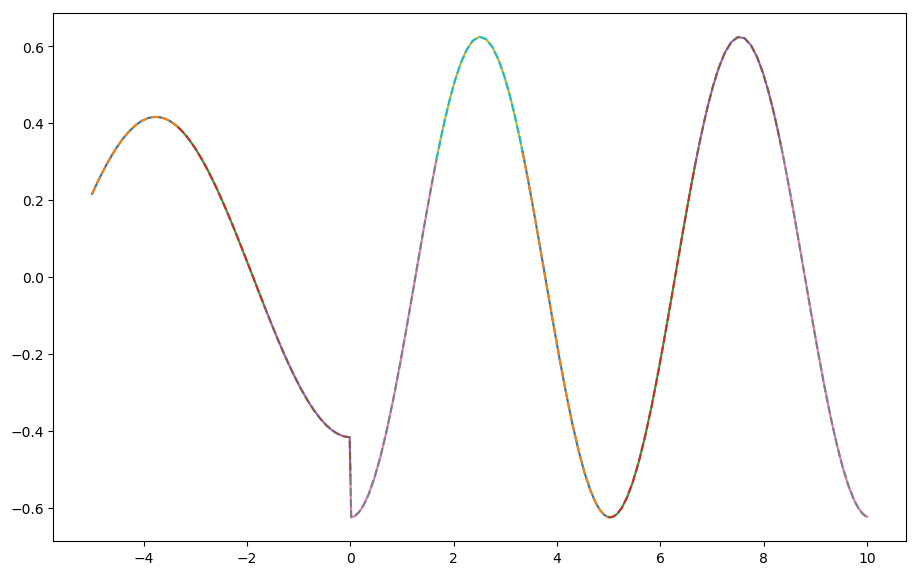

In [32]:
plt.figure(figsize=(11, 7), dpi=100)

for i in range(len(x)):
#     plt.plot(x[i],u[i])
    plt.plot(x[i],ini_du_dt[i])
    plt.plot(x[i],ana_du_dt(x,v,t)[i],ls = '--')

In [33]:
# direc = "delta_source_test_zero_initial"
# if os.path.isdir(direc):
#     print('Directory '+direc+' already exists')
# else:
#     os.makedirs(direc)
# images = []
for i in range(nt):
    beta = func_beta(start,end,t,xi_p,xi_int,x_p,x_p_dot)
    dx_dxi = func_dx_dxi(start, end, t,xi_p,xi_int,x_p)
    d2x_dxi2 = func_d2x_dxi2(start,end,t,xi_p,x_p)
    dbeta_dxi = func_dbeta_dxi(start,end,t,xi_p,xi_int,x_p,x_p_dot)
    un=u.copy()
    pn=p.copy()
    qn=q.copy()
    p= RK4_Step(dt, func_dp_dt,pn,un,qn,K,t,M_inv,M_inv_S,True,J1,J2,k_p,False,x_p,x_p_dot,beta,dx_dxi,d2x_dxi2)
    q= RK4_Step(dt, func_dq_dt,qn,un,pn,K,t,M_inv,M_inv_S,True,J1,J2,k_p,False,x_p,x_p_dot,beta,dx_dxi,dbeta_dxi) 
    u= RK4_Step(dt, func_du_dt,un,pn,qn,K,t,M_inv,M_inv_S,True,J1,J2,k_p,False,x_p,x_p_dot,beta,dx_dxi,d2x_dxi2)
    t+=dt
#     if i% int(nt/150)==0:
#         x = xi_to_x(xi_int,start,end,t,x_p,xi_p)
#         u_exact = ana_u(x,v,t)
#         plt.figure(figsize=(11, 7), dpi=100)
#         for i in range(len(x)):
#             plt.plot(x[i],u[i])
#             plt.plot(x[i],u_exact[i],ls ='--')
#         plt.title('u at t = '+str(np.round(t,3)))
#         plt.xlabel('x')
#         plt.ylim(-1,1)
#         plt.axvline(x_p(t),ls ='--',color = 'black')
#         plt.grid()        
#         #plt.legend()
#         name = direc+"/figure"+str(np.round(t,3))+'.png'
#         plt.savefig(name)
#         images.append(imageio.imread(name))
#         plt.close()
# gifName = direc+'/movie.gif'
# imageio.mimsave(gifName,images)
print(t)   

4.999912796397896


4.999912796397896


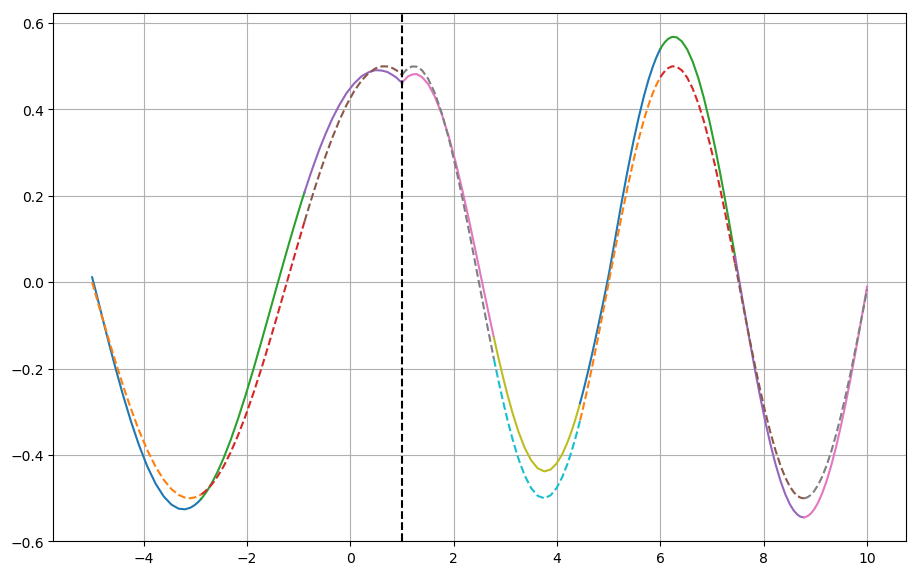

In [34]:
x = xi_to_x(xi_int,start,end,t,x_p,xi_p)
u_exact = ana_u(x,v,t)
plt.figure(figsize=(11, 7), dpi=100)
for i in range(len(x)):
    plt.plot(x[i],u[i])
    plt.plot(x[i],u_exact[i],ls ='--')
print(t)
plt.grid()
plt.axvline(x_p(t), ls ='--', color = 'black')
# plt.ylim(-5,5)

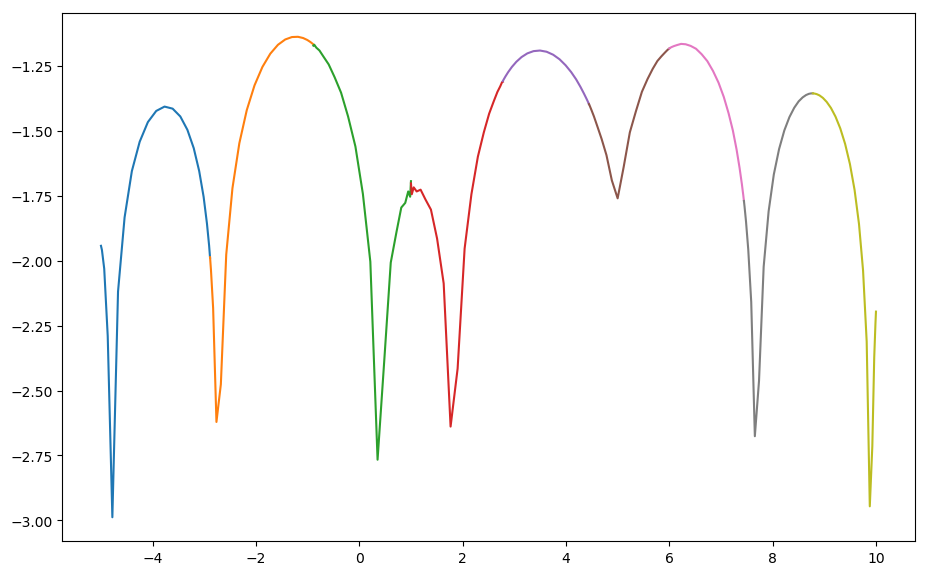

In [35]:
plt.figure(figsize=(11, 7), dpi=100)

for i in range(len(u)):
    plt.plot(x[i],np.log10(np.abs((u-u_exact)))[i])

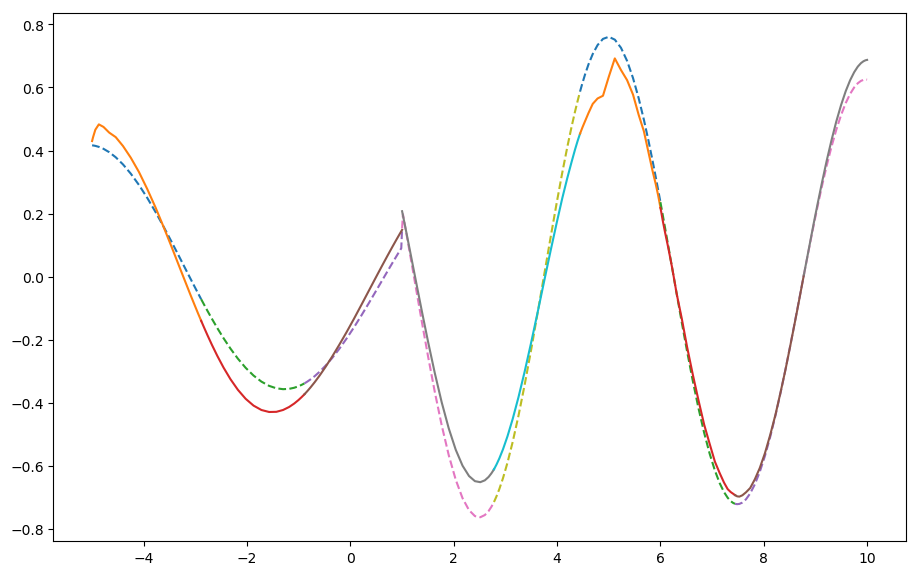

In [36]:
plt.figure(figsize=(11, 7), dpi=100)

beta_ = func_beta(start,end,t,xi_p,xi_int,x_p,x_p_dot)
q_exact = ana_du_dx(x,v,t)*dx_dxi
p_exact = beta_*q_exact - ana_du_dt(x,v,t)
for i in range(len(x)):
    plt.plot(x[i],p_exact[i],ls ='--')
    plt.plot(x[i],p[i])

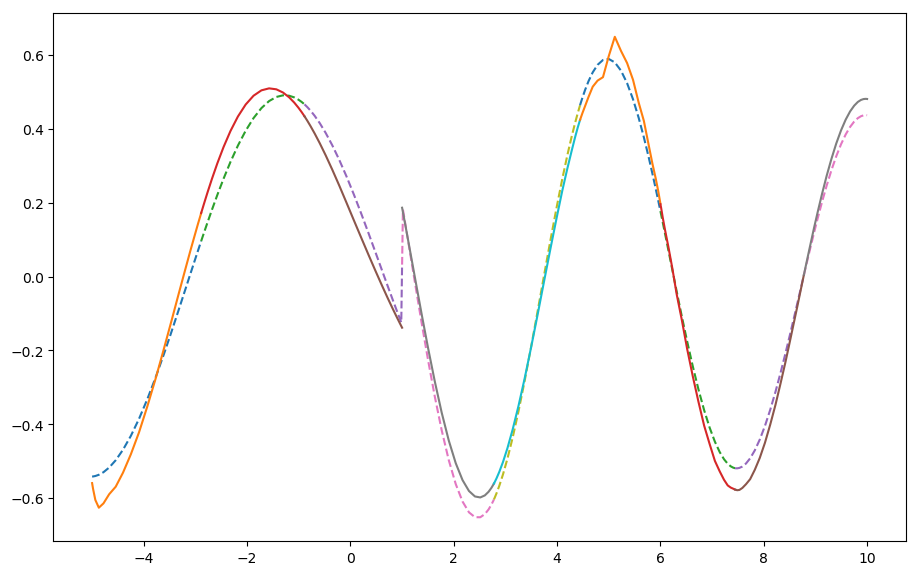

In [37]:
plt.figure(figsize=(11, 7), dpi=100)
for i in range(len(x)):
    plt.plot(x[i],q_exact[i],ls ='--')
    plt.plot(x[i],q[i])

(8, 10.5)

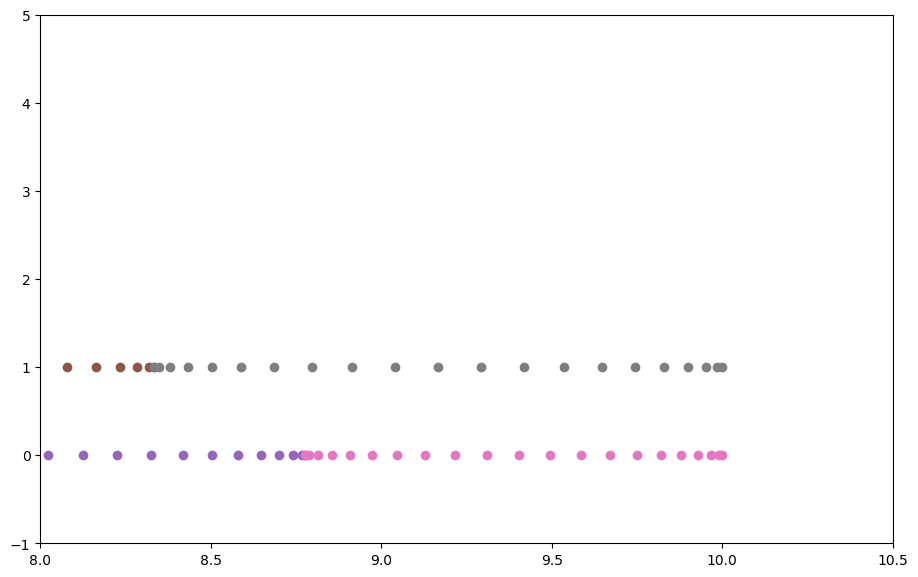

In [38]:
plt.figure(figsize=(11, 7), dpi=100)
plt.ylim(-1,5)
for i in range(len(x)):
    plt.scatter(x[i],np.zeros_like(x[i]))
    plt.scatter(xi_int[i],np.ones_like(xi_int[i]))
plt.xlim(8,10.5)

In [39]:
x

array([[-5.        , -4.98112428, -4.937188  , -4.86943887, -4.77958096,
        -4.66985666, -4.5429853 , -4.40208621, -4.25059219, -4.09215689,
        -3.93055967, -3.76961087, -3.61306039, -3.46451189, -3.32734451,
        -3.2046432 , -3.09913861, -3.01315675, -2.94857868, -2.90681261,
        -2.88889664],
       [-2.88889664, -2.87098911, -2.82930812, -2.76504124, -2.67981062,
        -2.57575016, -2.45544642, -2.32186477, -2.17826649, -2.02812018,
        -1.8750109 , -1.72255004, -1.57428854, -1.43363579, -1.30378585,
        -1.18765215, -1.0878114 , -1.00645684, -0.94536101, -0.90585023,
        -0.88890245],
       [-0.88890245, -0.87196311, -0.83253742, -0.77175278, -0.69114947,
        -0.59275285, -0.47901671, -0.3527525 , -0.21704997, -0.07519264,
         0.0694287 ,  0.21340163,  0.35337414,  0.48613114,  0.60866365,
         0.71822973,  0.81240664,  0.88913391,  0.94674749,  0.98400297,
         0.99998256],
       [ 0.99998256,  1.01595371,  1.05312411,  1.1104265 

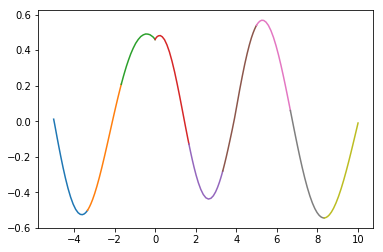

In [40]:
for i in range(len(xi_int)):
    plt.plot(xi_int[i],u[i])